# 构建数据集

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

## 导入数据

In [7]:
# df_merged 是原始数据
# df_merged_fe 是构建了比率类特征的数据
# df_merged_fe1 是构建了比率类和均值因子特征的数据

file_name = 'df_merged.csv'
df_merged = pd.read_csv(file_name)
df_merged.head()

,code,date,open,close,high,low,volumn,vwap,return,turn,free_turn
0,300581.SZ,2019-11-20,16.09,15.38,16.09,15.31,53958.70,15.6799,-4.3532,9.0444,10.6291
1,300591.SZ,2019-11-20,5.54,5.55,5.59,5.50,33148.60,5.5534,0.3617,2.8976,3.3202
2,300617.SZ,2019-11-20,20.94,21.02,21.25,20.94,2288.74,21.1140,-0.5206,0.6235,0.7071
3,300623.SZ,2019-11-20,22.34,22.27,22.65,22.08,92950.67,22.3585,-1.7644,8.7454,11.1543
4,300628.SZ,2019-11-20,72.50,72.75,73.23,71.81,26539.81,72.5632,0.5807,2.6711,2.6711


## 数据概况

In [8]:
df_merged.shape

(1098484, 11)

In [9]:
# df_merged.info()

In [10]:
pd.set_option('display.float_format', '{:.5}'.format)
display(df_merged.drop(['code', 'date'], axis=1).describe())
pd.reset_option('display.float_format')

,open,close,high,low,volumn,vwap,return,turn,free_turn
count,1.0985e+06,1.0985e+06,1.0985e+06,1.0985e+06,1.0985e+06,1.0985e+06,1.0985e+06,1.0985e+06,1.0985e+06
mean,30.301,30.333,31.008,29.666,6.5452e+04,30.334,0.075548,4.2058,5.18
std,39.462,39.521,40.518,38.493,2.2686e+05,39.491,3.1062,6.4044,15.976
min,2.11,2.11,2.12,2.08,1.0,2.1098,-28.032,0.0005,-110.03
25%,12.57,12.58,12.82,12.35,1.1879e+04,12.585,-1.4936,0.9529,1.5241
50%,19.76,19.77,20.18,19.36,2.5022e+04,19.775,0.0,2.0644,2.8736
75%,33.68,33.71,34.46,33.0,5.5818e+04,33.718,1.4019,4.6326,5.7905
max,951.0,951.5,996.0,858.0,3.6453e+07,931.68,30.0,86.551,5605.0


## 收益率

In [11]:
pd.set_option('display.float_format', '{:.5}'.format)
display(df_merged['return'].describe())
pd.reset_option('display.float_format')

count   1.0985e+06
mean      0.075548
std         3.1062
min        -28.032
25%        -1.4936
50%            0.0
75%         1.4019
max           30.0
Name: return, dtype: float64

/Users/ryanl/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


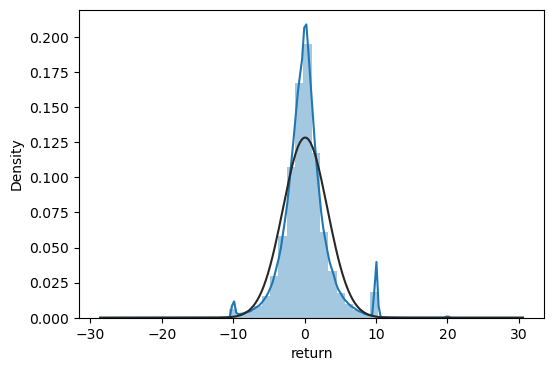

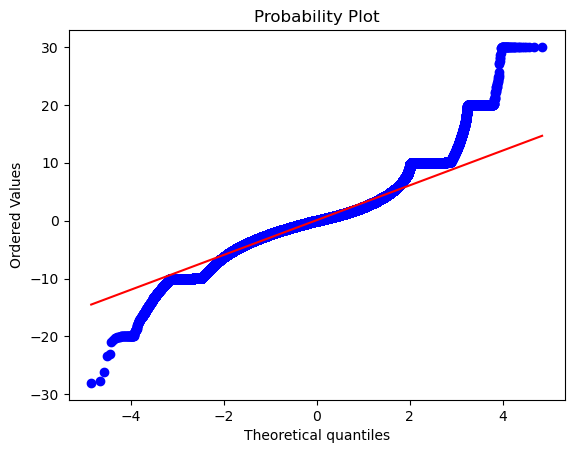

In [12]:
from scipy import stats
from scipy.stats import norm

plt.figure(figsize=(6,4))
sns.distplot(df_merged['return'], fit=norm)
plt.plot()
fig = plt.figure()
res = stats.probplot(df_merged['return'], plot=plt)

In [13]:
print("Skewness: %f" % df_merged['return'].skew())
print("Kurtosis: %f" % df_merged['return'].kurt())

Skewness: 0.559080
Kurtosis: 3.881802


## 标准化特征

In [14]:
# 创建标签列，保留不变
df_merged['target'] = df_merged['return']

# 对每个特征分别进行归一化
for feature in df_merged.columns[2:-1]:
    df_merged[feature] = (df_merged[feature] - df_merged[feature].mean()) / df_merged[feature].std()

df_merged.head()

,code,date,open,close,high,low,volumn,vwap,return,turn,free_turn,target
0,300581.SZ,2019-11-20,-0.360131,-0.378343,-0.368181,-0.372960,-0.050663,-0.371060,-1.425764,0.755505,0.341083,-4.3532
1,300591.SZ,2019-11-20,-0.627479,-0.627069,-0.627327,-0.627814,-0.142394,-0.627484,0.092122,-0.204270,-0.116415,0.3617
2,300617.SZ,2019-11-20,-0.237228,-0.235636,-0.240829,-0.226698,-0.278424,-0.233458,-0.191920,-0.559353,-0.279981,-0.5206
3,300623.SZ,2019-11-20,-0.201750,-0.204007,-0.206276,-0.197082,0.121213,-0.201945,-0.592342,0.708818,0.373958,-1.7644
4,300628.SZ,2019-11-20,1.069355,1.073275,1.042067,1.094855,-0.171525,1.069339,0.162625,-0.239636,-0.157045,0.5807


## 构建特征图&标签

每隔10个交易日采样（防止过于频繁的采样导致数据相似度太高）

In [15]:
X, Y, Y_dates, empty = [], [], [], []


for code in tqdm(df_merged['code'].unique()):
    
    x, y, dates = [], [], []
    
    # 每个个股单独采样
    df = df_merged[df_merged['code']==code]
    
    i = 0
    while i + 40 < len(df):
        
        # 标签对应的日期
        date = df.iloc[i+40]['date']
        dates.append(date)
        
        # 特征：30天的历史窗口，构建 ”数据图片“
        window = df.iloc[i:i+30, 1:-1]
        window.set_index('date', inplace=True)
        window = window.transpose()
        x.append(np.array(window))
        
        # 标签：第i+40天的收益率
        y.append(df.iloc[i+40]['target'])
        
        # 每间隔10个交易日采样一次
        i += 10
    
    # 如果该个股的数据不够，跳过
    if not x or not y:
        empty.append(code)
        continue
    
    # 将该个股的所有的 样本-标签 组合加入到数据集中
    x = np.stack(x)
    y = np.stack(y)
    y_dates = np.stack(dates)
    X.append(x)
    Y.append(y)
    Y_dates.append(y_dates)


# 根据标签日期对数据集进行排序
Y_dates = np.concatenate(Y_dates, axis=0)
order = np.argsort(Y_dates)
X = np.concatenate(X, axis=0)[order]
Y = np.concatenate(Y, axis=0)[order]
Y_dates = Y_dates[order]

print('Shape of X: ', X.shape)
print('Shape of Y: ', Y.shape)
print('Stocks with not enough data: ', empty)

100%|███████████████████████████████████████| 1194/1194 [01:45<00:00, 11.28it/s]


Shape of X:  (105637, 9, 30)
Shape of Y:  (105637,)
Stocks with not enough data:  ['834261.BJ', '831304.BJ', '839792.BJ', '830896.BJ', '872895.BJ', '873593.BJ', '833394.BJ', '871694.BJ', '837006.BJ', '871478.BJ', '838837.BJ', '836699.BJ', '832471.BJ', '839719.BJ']


## 标签转换

In [45]:
# 构建超额收益标签：判断个股在对应日期的收益率是否超过当天的市场均值，超过则标签为1，否则为0

memo = {}
Y_cls = []

for i in tqdm(range(len(Y))):
    
    # 目标日期
    date = Y_dates[i]
    
    # 获取当天的市场收益率均值
    if date in memo:
        avg = memo[date]
    else:
        avg = df_merged[df_merged['date']==date]['target'].mean()
        memo[date] = avg
    
    # 判断标签取值
    if Y[i] > avg:
        Y_cls.append(1)
    else:
        Y_cls.append(0)

100%|██████████████████████████████████| 105637/105637 [01:59<00:00, 884.97it/s]


In [46]:
Y_cls = np.array(Y_cls)
Y_cls.shape

(105637,)

In [47]:
Y_cls[:10]

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1])

## 标准化收益率

In [11]:
np.mean(Y), np.std(Y)

(0.08304253433929398, 3.092383135172094)

In [13]:
Y[:5]

array([-1.5487,  0.    ,  3.8362,  0.4219,  0.0717])

In [12]:
# 标准化收益率标签
Y_norm = (Y - np.mean(Y)) / np.std(Y)

np.mean(Y_norm), np.std(Y_norm)

(9.685825416232422e-18, 1.0)

In [14]:
Y_norm[:5]

array([-0.52766506, -0.0268539 ,  1.21367803,  0.1095781 , -0.00366789])

## 储存数据集

In [49]:
# 储存数据集到本地
np.save('X_fe.npy', X)
np.save('Y_fe_cls.npy', Y_cls)
np.save('Y_fe_norm.npy', Y_norm)
np.save('Y_dates.npy', Y_dates)